In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core                 import fit_functions as fitf

In [2]:
def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    y, x, p = plt.hist(*args, **kwargs)
    return y, shift_to_bin_centers(x), p


def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    z, x, y, p = plt.hist2d(*args, **kwargs)
    return z, shift_to_bin_centers(x), shift_to_bin_centers(y), p

def hist2d_profile(x, y, z, nbinx, nbiny, xrange, yrange, **kwargs):
    """
    Create a profile 2d of the data and plot it as an histogram.
    """
    x, y, z, ze = fitf.profileXY(x, y, z, nbinx, nbiny, xrange, yrange)
    plot_output = display_matrix(x, y, z, **kwargs)
    return ((x, y, z, ze), *plot_output)

def display_matrix(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = x = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
    else:
        mask = mask.flatten()
    h  = hist2d(x_[mask], y_[mask], (x_binning,
                                     y_binning),
                weights = z_[mask],
                **kwargs)
    return h, plt.colorbar()

def create_new_figure(kwargs):
    if kwargs.setdefault("new_figure", True):
        plt.figure()
    del kwargs["new_figure"]

def labels(xlabel, ylabel, title=""):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title ( title)

In [3]:
file_name = "flex.kr83m.1.s3mmp15mm.nexus.h5"
this_dir = "/Users/taylorcontreras/Development/Research/Odyssey_sipmstudy/"

(array([ 2.,  1.,  7.,  5.,  3.,  7.,  6.,  7.,  8., 13., 10., 15.,  9.,
         6.,  1.]),
 array([ 4.        ,  5.06666667,  6.13333333,  7.2       ,  8.26666667,
         9.33333333, 10.4       , 11.46666667, 12.53333333, 13.6       ,
        14.66666667, 15.73333333, 16.8       , 17.86666667, 18.93333333,
        20.        ]),
 <a list of 15 Patch objects>)

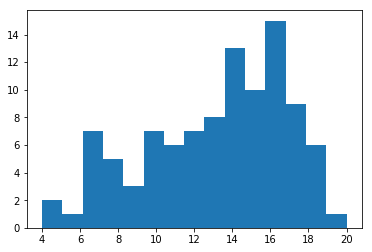

In [4]:
# Get all sensor responses and all the sensor positions
sns_response = pd.read_hdf(this_dir+file_name, 'MC/sns_response')
sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
sipm_response = sipm_response.loc[sipm_response["time_bin"] >0]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]
pmt_response = pmt_response.loc[pmt_response["time_bin"] >0]

pmt_time_binning = .025 # microseconds (25ns)
sipm_time_binning = 1.0 # microseconds

times_sipm = sipm_response.groupby(['event_id']).apply(lambda group: group['time_bin'].max() - group['time_bin'].min())
plt.hist(times_sipm*sipm_time_binning, bins=15)


In [5]:
dark_rate = 0.1 # MHz/mm^2 (inverse in microseconds)
# Dark count per sipm = event time x sipm size x dark count
sipm_size = 3.**2.
dark_count = times_sipm*sipm_size*dark_rate
dark_count

event_id
100    15.3
101     9.0
102    13.5
103    14.4
104     9.9
105    15.3
106    12.6
107    14.4
108    11.7
109     9.0
110    15.3
111    14.4
112    14.4
113    13.5
114    14.4
115    16.2
116    14.4
117    11.7
118     6.3
119    12.6
120    11.7
121    12.6
122     5.4
123    14.4
124     8.1
125    13.5
126    10.8
127    13.5
128     9.0
129    14.4
       ... 
170    14.4
171    13.5
172    16.2
173    18.0
174    11.7
175     6.3
176    14.4
177    14.4
178    13.5
179    15.3
180     6.3
181    13.5
182     7.2
183     8.1
184    12.6
185     6.3
186    10.8
187    15.3
188    16.2
189    10.8
190     9.0
191    11.7
192    10.8
193    13.5
194    12.6
195    14.4
196     9.9
197    10.8
198     8.1
199     9.0
Length: 100, dtype: float64

In [6]:
def Thresh_by_Event(group, args=dark_count):
    event = group.event_id.max()
    thresh = dark_count[event]
    return group[group.charge > thresh]

def Center_of_Event(sipm_response_in_event, sipm_positions):
    sensor_ids = sipm_response_in_event.sensor_id
    sensor_positions = sipm_positions.loc[sensor_ids]
    
    denominator = np.sum(sipm_response_in_event.charge)
    numerator = np.sum(sipm_response_in_event.set_index('sensor_id').charge*sensor_positions)

    return numerator/denominator

#thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event).set_index('event_id').groupby('event_id')

In [7]:
sipm_response_by_event = sipm_response.groupby('event_id')
thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event, args=(dark_count)).set_index('event_id').groupby('event_id')
#for _, grp in sipm_response_by_event:
#    print(grp.event_id.max())


In [8]:
thresh_sipm_response

In [9]:

sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')

# Sort to get the sipm positions
sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

# Create separate dataframes for the sipm and pmt response
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]

# Summed pmt energy per event
response_perevent_pmt = pmt_response.groupby('event_id')
summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

# Summed sipm energy per event
response_perevent_sipm = sipm_response.groupby('event_id')
summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})

# Position of the event(sipm with the max charge)
idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
new_max_sipm_positions = sipm_positions.set_index('sensor_id')
this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()] 
event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id')

pmt_map = pd.concat([summed_charges_byevent_pmt,event_map],axis=1)
sipm_map = pd.concat([summed_charges_byevent_sipm,event_map],axis=1)

# Make position a function of r
pmt_r = pmt_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
pmt_r = pmt_r.to_frame()
pmt_r = pmt_r.rename(columns = {pmt_r.columns[0]:'r'})
pmt_map = pd.concat([pmt_map, pmt_r],axis=1).sort_values(by='r')
sipm_r = sipm_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
sipm_r = sipm_r.to_frame()
sipm_r = sipm_r.rename(columns = {sipm_r.columns[0]:'r'})
sipm_map = pd.concat([sipm_map, sipm_r],axis=1).sort_values(by='r')

event_x = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').x))
event_x = pd.DataFrame({'event_id':event_x.index,'x':event_x.values}).set_index('event_id')
event_y = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').y))
event_y = pd.DataFrame({'event_id':event_y.index,'y':event_y.values}).set_index('event_id')

sipm_charge = sipm_response_by_event.agg({"charge":"sum"}).rename(columns={'charge':'sipm_charge'})
pmt_charge = pmt_response.groupby('event_id').agg({"charge":"sum"}).rename(columns={'charge':'pmt_charge'})
kr_map = pd.concat([pmt_charge,sipm_charge,event_x,event_y],axis=1)
kr_map

,pmt_charge,sipm_charge,x,y
event_id,,,,
100,7420,8192,140.906012,348.969094
101,7387,7937,181.833232,342.855508
102,6780,7270,459.191362,11.945248
103,7346,7877,-0.493579,-404.524478
104,7790,7809,236.413043,-142.134977
105,6319,6986,378.539564,-270.336092
106,6797,7289,450.250603,-62.079745
107,7485,8032,331.730769,-185.392465
108,8043,7879,-94.801020,37.147959


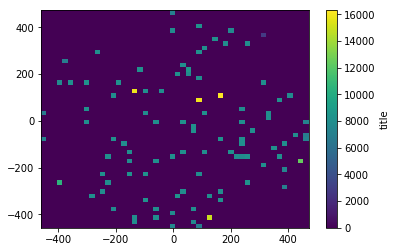

In [10]:
plt.hist2d(sipm_map.x, sipm_map.y, weights = sipm_map.charge, bins=[50,50])
plt.colorbar(label='title')